<a href="https://colab.research.google.com/github/ankitagithub13/capstone-chatbot/blob/Modeling/Vanila_BERT_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Setting the current working directory

import sys
import os

py_file_location = "/content/gdrive/My Drive"
sys.path.append(os.path.abspath(py_file_location))

In [2]:
import numpy as np
import pandas as pd
import spacy
import nltk
import re

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk import stem,tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem
from nltk.tokenize import word_tokenize

#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Data Set - industrial_safety_and_health_database_with_accidents_description.csv',index_col=False)

In [4]:
print(df.shape)

df.head()

(425, 11)


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [5]:
# Drop and Rename Columns 
df.drop("Unnamed: 0", axis=1, inplace=True)
df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee type'}, inplace=True)
df.head(3)

,Date,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...


In [6]:
df.columns

Index(['Date', 'Country', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee type', 'Critical Risk',
       'Description'],
      dtype='object')

In [7]:
# Check Null Values
df.isnull().sum()

Date                        0
Country                     0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee type               0
Critical Risk               0
Description                 0
dtype: int64

**Preprocess**

In [9]:
# Add this pre_processor.py file in temp location to execute this
import pre_processor
from pre_processor import pre_process_data

x = pre_process_data()

df["CleanDescription"] = x.pre_process(df['Description'], 
                    lower_flag=1,
                    remove_spaces_flag=1, 
                    remove_new_line_flag=1,
                    remove_special_char_flag=1,  
                    remove_numbers_flag=1,  
                    replace_appos_flag=1,
                    remove_stop_words_flag=1,  
                    remove_single_letter_word_flag=1,
                    remove_two_letter_word_flag=1,
                    lemmatize_the_words_flag=0, 
                    stem_the_words_flag=0)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df[['Description','CleanDescription']].head()

,Description,CleanDescription
0,While removing the drill rod of the Jumbo 08 f...,removing drill rod jumbo maintenance superviso...
1,During the activation of a sodium sulphide pum...,activation sodium sulphide pump piping uncoupl...
2,In the sub-station MILPO located at level +170...,substation milpo located level collaborator ex...
3,Being 9:45 am. approximately in the Nv. 1880 C...,approximately cx personnel begins task unlocki...
4,Approximately at 11:45 a.m. in circumstances t...,approximately circumstances mechanics anthony ...


In [11]:
df['Potential Accident Level'].head()

0     IV
1     IV
2    III
3      I
4     IV
Name: Potential Accident Level, dtype: object

In [12]:
df['Potential Accident Level'].unique()

array(['IV', 'III', 'I', 'II', 'V', 'VI'], dtype=object)

In [13]:
df['PAL_label'] = df['Potential Accident Level'].replace({'I' :0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':4})

In [14]:
df.PAL_label.unique()

array([3, 2, 0, 1, 4])

***BERT***

In [16]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [17]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
import os
import re
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.



In [36]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [20]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [21]:
import tensorflow_hub as hub
import tokenization
bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1, Total size: 320.89MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1'.


In [22]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [24]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    output = bert_layer({'input_word_ids':input_word_ids,
                                                 'input_mask': input_mask, 
                                                 'input_type_ids': segment_ids})
    clf_output = output['pooled_output']
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Load Data

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.CleanDescription.values, df.PAL_label.values, test_size=0.2, random_state=53)

print('training dataset length: {}'.format(X_train.shape[0]))
print('test dataset length: {}'.format(X_test.shape[0]))

print("y_train :", set(y_train))

print('training dataset length: {}'.format(X_train.shape[0]))
print('test dataset length: {}'.format(X_test.shape[0]))
print('y_train: {}'.format(set(y_train)))

training dataset length: 340
test dataset length: 85
y_train : {0, 1, 2, 3, 4}
training dataset length: 340
test dataset length: 85
y_train: {0, 1, 2, 3, 4}


In [35]:
max_len = 100
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(y_train)

model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 7 81130753    input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

In [ ]:
history = model.fit(train_input, train_labels, epochs=20,
          validation_split=0.2,
          batch_size=32)

Epoch 1/20
9/9 [==============================] - 241s 25s/step - loss: 1.7027 - accuracy: 0.2206 - val_loss: 1.5498 - val_accuracy: 0.3529
Epoch 2/20
9/9 [==============================] - 219s 24s/step - loss: 1.5512 - accuracy: 0.3309 - val_loss: 1.5381 - val_accuracy: 0.3088
Epoch 3/20
9/9 [==============================] - 223s 25s/step - loss: 1.5528 - accuracy: 0.2904 - val_loss: 1.4788 - val_accuracy: 0.4118
Epoch 4/20
9/9 [==============================] - 220s 24s/step - loss: 1.4963 - accuracy: 0.3456 - val_loss: 1.4555 - val_accuracy: 0.3235
Epoch 5/20
9/9 [==============================] - 220s 24s/step - loss: 1.4658 - accuracy: 0.3750 - val_loss: 1.4486 - val_accuracy: 0.3382
Epoch 6/20
9/9 [==============================] - 220s 24s/step - loss: 1.3951 - accuracy: 0.4338 - val_loss: 1.4261 - val_accuracy: 0.3676
Epoch 7/20
9/9 [==============================] - 219s 24s/step - loss: 1.4108 - accuracy: 0.3750 - val_loss: 1.4236 - val_accuracy: 0.3382
Epoch 8/20
9/9 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


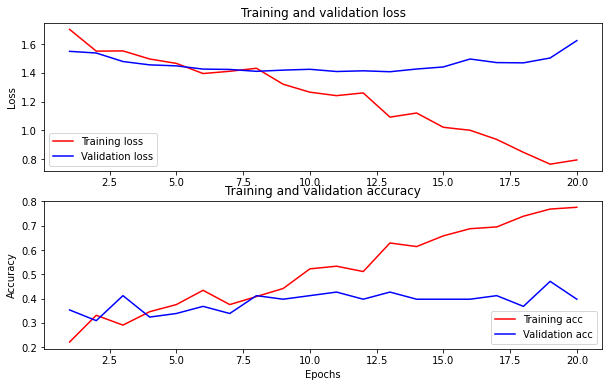

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
preds = np.argmax(model.predict(test_input, batch_size=16), axis=1)

In [ ]:
pred_dict = {'I' :0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':4}

In [ ]:
# X_train, X_test, y_train, y_test

In [ ]:
for text, pred, actual in zip(X_test, preds, y_test):
  text = text
  pred_dict[pred] = pred
  pred_dict[actual] = actual 

In [ ]:
pd.DataFrame([(text, pred_dict[pred], pred_dict[actual]) for text, pred, actual in zip(X_test, preds, y_test)],
             columns=['Sentence', 'Predicted', 'Actual'])

,Sentence,Predicted,Actual
0,injured collaborators time making hdpe pipe us...,3,2
1,driver aeq plate dump truck ton heading loadin...,2,3
2,performing doosan equipment hammer repair empl...,1,2
3,moments maperu truck plate returned city pasco...,4,3
4,approx hours luis maintenance team mobile equi...,2,1
...,...,...,...
80,level guide wire chamber preparation activity ...,1,3
81,level unicon plant collaborator shuttering wor...,3,0
82,employee reports attempting manually ingot zin...,3,3
83,soil sampling region sta employees rafael dani...,3,0


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 2  3  2  4  0]
 [ 0  8  3  3  0]
 [ 1  6  4 12  0]
 [ 1  6  4 18  2]
 [ 0  2  0  4  0]]
              precision    recall  f1-score   support

           0       0.50      0.18      0.27        11
           1       0.32      0.57      0.41        14
           2       0.31      0.17      0.22        23
           3       0.44      0.58      0.50        31
           4       0.00      0.00      0.00         6

    accuracy                           0.38        85
   macro avg       0.31      0.30      0.28        85
weighted avg       0.36      0.38      0.34        85

